In [2]:
import os
from torchvision import datasets , transforms
from torch.utils.data import DataLoader
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Load Data

In [4]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2,contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]) # We find these values from the ImageNet dataset
])

In [5]:
dataset_path = "./dataset"
dataset=datasets.ImageFolder(root=dataset_path,transform=image_transforms)
len(dataset)

2300

In [36]:
class_names=dataset.classes
class_names

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [7]:
num_classes = len(dataset.classes)
num_classes

6

In [8]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size

train_size , val_size

(1725, 575)

In [9]:
from torch.utils.data import random_split

train_dataset,val_dataset=random_split(dataset,[train_size,val_size])

In [10]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=32,shuffle=True)

In [11]:
for images , labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [12]:
images[0].shape

torch.Size([3, 224, 224])

In [13]:
labels[1]

tensor(1)

In [14]:
images[1].permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8096584..2.3611329].


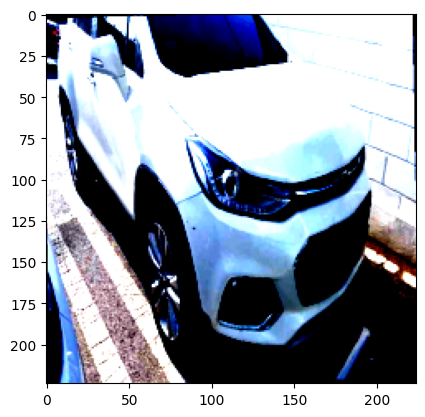

In [15]:
plt.imshow(images[1].permute(1,2,0))

### Model : CNN

In [16]:
class CarClassifier(nn.Module) :
    def __init__(self,num_classes) :
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1), # image of size (224,224) with 3 channels (3,224,224) output : (16,224,224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), # output : (16,112,112)
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1), # image of size (112,112) with 16 channels (16,112,112) output : (32,112,112)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), # output : (32,56,56)
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), # image of size (56,56) with 32 channels (32,56,56) output : (64,56,56)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), # output : (64,28,28)
            nn.Flatten(),
            nn.Linear(64*28*28,512),
            nn.ReLU(),
            nn.Linear(512,num_classes),
        )
    def forward(self, x) :
        x=self.network(x)
        return x

In [17]:
model = CarClassifier(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")
        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    return all_labels, all_predictions

In [19]:
all_labels , all_predictions=  train_model(model,criterion,optimizer,epochs=10)

Batch: 10, Epoch: 1, Loss: 1.80
Batch: 20, Epoch: 1, Loss: 1.78
Batch: 30, Epoch: 1, Loss: 1.76
Batch: 40, Epoch: 1, Loss: 1.79
Batch: 50, Epoch: 1, Loss: 1.75
Epoch [1/10], Avg Loss: 1.9786
*** Validation Accuracy: 27.13% ***
Batch: 10, Epoch: 2, Loss: 1.73
Batch: 20, Epoch: 2, Loss: 1.66
Batch: 30, Epoch: 2, Loss: 1.72
Batch: 40, Epoch: 2, Loss: 1.43
Batch: 50, Epoch: 2, Loss: 1.40
Epoch [2/10], Avg Loss: 1.6078
*** Validation Accuracy: 38.43% ***
Batch: 10, Epoch: 3, Loss: 1.33
Batch: 20, Epoch: 3, Loss: 1.30
Batch: 30, Epoch: 3, Loss: 0.97
Batch: 40, Epoch: 3, Loss: 1.30
Batch: 50, Epoch: 3, Loss: 1.26
Epoch [3/10], Avg Loss: 1.3132
*** Validation Accuracy: 53.39% ***
Batch: 10, Epoch: 4, Loss: 1.25
Batch: 20, Epoch: 4, Loss: 1.18
Batch: 30, Epoch: 4, Loss: 1.25
Batch: 40, Epoch: 4, Loss: 1.11
Batch: 50, Epoch: 4, Loss: 1.14
Epoch [4/10], Avg Loss: 1.2513
*** Validation Accuracy: 49.74% ***
Batch: 10, Epoch: 5, Loss: 0.84
Batch: 20, Epoch: 5, Loss: 1.17
Batch: 30, Epoch: 5, Loss: 1

1. As the training model loss is decresing and the validation loss is increasing, the model is overfitting.
2. model is over fitting to training data  - training loss is very less
3. but the loss on unseen data ( validation data ) - higher



### Model : CNN With Regularization

In [20]:
class CarClassifierCNNWithregularization(nn.Module) :
    def __init__(self,num_classes) :
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1), # image of size (224,224) with 3 channels (3,224,224) output : (16,224,224)
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), # output : (16,112,112)
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1), # image of size (112,112) with 16 channels (16,112,112) output : (32,112,112)
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), # output : (32,56,56)
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), # image of size (56,56) with 32 channels (32,56,56) output : (64,56,56)
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), # output : (64,28,28)
            nn.Flatten(),
            nn.Linear(64*28*28,512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512,num_classes),
        )
    def forward(self, x) :
        x=self.network(x)
        return x

In [21]:
model = CarClassifierCNNWithregularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-4)

In [22]:
all_labels , all_predictions=  train_model(model,criterion,optimizer,epochs=10)

Batch: 10, Epoch: 1, Loss: 8.73
Batch: 20, Epoch: 1, Loss: 6.59
Batch: 30, Epoch: 1, Loss: 2.64
Batch: 40, Epoch: 1, Loss: 1.73
Batch: 50, Epoch: 1, Loss: 1.47
Epoch [1/10], Avg Loss: 6.2239
*** Validation Accuracy: 46.78% ***
Batch: 10, Epoch: 2, Loss: 1.32
Batch: 20, Epoch: 2, Loss: 1.45
Batch: 30, Epoch: 2, Loss: 1.64
Batch: 40, Epoch: 2, Loss: 1.57
Batch: 50, Epoch: 2, Loss: 1.52
Epoch [2/10], Avg Loss: 1.4271
*** Validation Accuracy: 48.87% ***
Batch: 10, Epoch: 3, Loss: 1.21
Batch: 20, Epoch: 3, Loss: 1.16
Batch: 30, Epoch: 3, Loss: 1.09
Batch: 40, Epoch: 3, Loss: 1.62
Batch: 50, Epoch: 3, Loss: 1.48
Epoch [3/10], Avg Loss: 1.3113
*** Validation Accuracy: 51.83% ***
Batch: 10, Epoch: 4, Loss: 1.25
Batch: 20, Epoch: 4, Loss: 1.30
Batch: 30, Epoch: 4, Loss: 1.38
Batch: 40, Epoch: 4, Loss: 1.32
Batch: 50, Epoch: 4, Loss: 1.31
Epoch [4/10], Avg Loss: 1.2552
*** Validation Accuracy: 50.96% ***
Batch: 10, Epoch: 5, Loss: 1.28
Batch: 20, Epoch: 5, Loss: 1.44
Batch: 30, Epoch: 5, Loss: 1

### Model : Transfer Learning with EffecientNet

In [23]:
model=models.efficientnet_b0(weights="DEFAULT")
model.classifier[1].in_features

1280

In [24]:
class CarClassifierEfficientNet(nn.Module):
    def __init_(self,num_classes) :
        super().__init__()
        self.network = models.efficientnet_b0(weights="DEFAULT")

        for param in self.network.parameters() :
            param.requires_grad = False # Freezing the Layers

        in_features = self.model.classifier[1].in_features
        
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features, num_classes),
        )
    def forward(self, x) :
        x = self.model(x)
        return x

In [25]:
model = CarClassifierCNNWithregularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

In [26]:
train_model(model,criterion,optimizer,epochs=10)

Batch: 10, Epoch: 1, Loss: 12.59
Batch: 20, Epoch: 1, Loss: 3.35
Batch: 30, Epoch: 1, Loss: 1.90
Batch: 40, Epoch: 1, Loss: 1.33
Batch: 50, Epoch: 1, Loss: 1.41
Epoch [1/10], Avg Loss: 7.5079
*** Validation Accuracy: 42.96% ***
Batch: 10, Epoch: 2, Loss: 1.52
Batch: 20, Epoch: 2, Loss: 1.33
Batch: 30, Epoch: 2, Loss: 1.27
Batch: 40, Epoch: 2, Loss: 1.45
Batch: 50, Epoch: 2, Loss: 1.34
Epoch [2/10], Avg Loss: 1.3169
*** Validation Accuracy: 54.96% ***
Batch: 10, Epoch: 3, Loss: 1.13
Batch: 20, Epoch: 3, Loss: 1.08
Batch: 30, Epoch: 3, Loss: 1.35
Batch: 40, Epoch: 3, Loss: 1.22
Batch: 50, Epoch: 3, Loss: 1.30
Epoch [3/10], Avg Loss: 1.2458
*** Validation Accuracy: 53.74% ***
Batch: 10, Epoch: 4, Loss: 0.96
Batch: 20, Epoch: 4, Loss: 0.91
Batch: 30, Epoch: 4, Loss: 1.16
Batch: 40, Epoch: 4, Loss: 1.37
Batch: 50, Epoch: 4, Loss: 1.07
Epoch [4/10], Avg Loss: 1.1915
*** Validation Accuracy: 53.22% ***
Batch: 10, Epoch: 5, Loss: 1.39
Batch: 20, Epoch: 5, Loss: 1.30
Batch: 30, Epoch: 5, Loss: 

([np.int64(0),
  np.int64(4),
  np.int64(4),
  np.int64(2),
  np.int64(5),
  np.int64(3),
  np.int64(4),
  np.int64(3),
  np.int64(1),
  np.int64(2),
  np.int64(0),
  np.int64(1),
  np.int64(2),
  np.int64(2),
  np.int64(2),
  np.int64(1),
  np.int64(2),
  np.int64(4),
  np.int64(2),
  np.int64(0),
  np.int64(4),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(5),
  np.int64(0),
  np.int64(0),
  np.int64(5),
  np.int64(2),
  np.int64(2),
  np.int64(4),
  np.int64(0),
  np.int64(0),
  np.int64(5),
  np.int64(5),
  np.int64(2),
  np.int64(0),
  np.int64(0),
  np.int64(2),
  np.int64(0),
  np.int64(3),
  np.int64(2),
  np.int64(1),
  np.int64(2),
  np.int64(4),
  np.int64(0),
  np.int64(5),
  np.int64(2),
  np.int64(4),
  np.int64(4),
  np.int64(3),
  np.int64(4),
  np.int64(2),
  np.int64(4),
  np.int64(5),
  np.int64(5),
  np.int64(5),
  np.int64(0),
  np.int64(2),
  np.int64(0),
  np.int64(2),
  np.int64(4),
  np.int64(5),
  np.int64(1),
  np.int64(2),
  np.int64(2),
  np.int64

### Transfer Learning with ResNet

In [27]:
# Load the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True            

        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [28]:
model = CarClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.04
Batch: 20, Epoch: 1, Loss: 1.24
Batch: 30, Epoch: 1, Loss: 0.59
Batch: 40, Epoch: 1, Loss: 0.80
Batch: 50, Epoch: 1, Loss: 0.49
Epoch [1/10], Avg Loss: 0.8629
*** Validation Accuracy: 69.91% ***
Batch: 10, Epoch: 2, Loss: 0.64
Batch: 20, Epoch: 2, Loss: 0.43
Batch: 30, Epoch: 2, Loss: 0.35
Batch: 40, Epoch: 2, Loss: 0.70
Batch: 50, Epoch: 2, Loss: 0.29
Epoch [2/10], Avg Loss: 0.5374
*** Validation Accuracy: 73.22% ***
Batch: 10, Epoch: 3, Loss: 0.31
Batch: 20, Epoch: 3, Loss: 0.36
Batch: 30, Epoch: 3, Loss: 0.32
Batch: 40, Epoch: 3, Loss: 0.46
Batch: 50, Epoch: 3, Loss: 0.22
Epoch [3/10], Avg Loss: 0.3618
*** Validation Accuracy: 79.65% ***
Batch: 10, Epoch: 4, Loss: 0.14
Batch: 20, Epoch: 4, Loss: 0.27
Batch: 30, Epoch: 4, Loss: 0.20
Batch: 40, Epoch: 4, Loss: 0.21
Batch: 50, Epoch: 4, Loss: 0.28
Epoch [4/10], Avg Loss: 0.2611
*** Validation Accuracy: 77.74% ***
Batch: 10, Epoch: 5, Loss: 0.23
Batch: 20, Epoch: 5, Loss: 0.36
Batch: 30, Epoch: 5, Loss: 0

### Model Evaluation using Confusion matrix and Classification report

In [32]:
print(labels[:10] )
print(predictions[:10])

[np.int64(1), np.int64(3), np.int64(4), np.int64(5), np.int64(2), np.int64(2), np.int64(0), np.int64(0), np.int64(0), np.int64(4)]
[np.int64(0), np.int64(4), np.int64(1), np.int64(5), np.int64(2), np.int64(2), np.int64(0), np.int64(0), np.int64(0), np.int64(4)]


In [33]:
from sklearn.metrics import classification_report

report=classification_report(labels,predictions)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       145
           1       0.72      0.75      0.73        92
           2       0.89      0.90      0.89       130
           3       0.76      0.74      0.75        61
           4       0.70      0.69      0.70        72
           5       0.85      0.83      0.84        75

    accuracy                           0.81       575
   macro avg       0.80      0.79      0.80       575
weighted avg       0.81      0.81      0.81       575



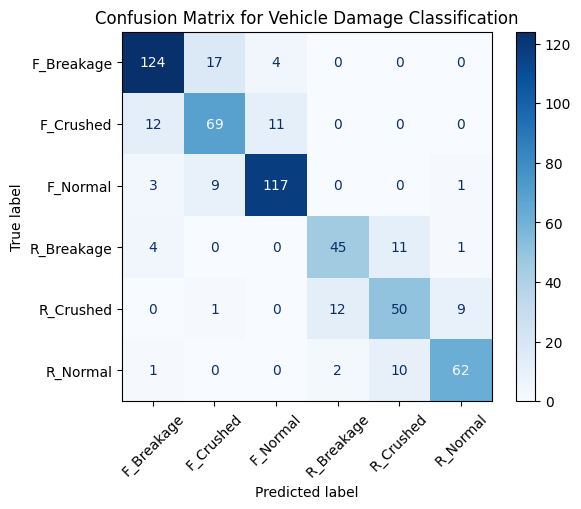

In [38]:
import numpy as np 
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(labels,predictions,labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=class_names)
disp.plot(cmap=plt.cm.Blues,xticks_rotation=45)
plt.title('Confusion Matrix for Vehicle Damage Classification')
plt.show()

In [39]:
torch.save(model.state_dict(),"saved_model.pth")